
<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/fr/b/bb/UQO_Logo.png" alt="UQO" height="120">
  

  <h4 align="center"><b>Technique d'apprentissage[6243] - Enseignant : Allili Mohand Said</b></h4>
  <br>
  <h4 align="center"><b>Projet - IA pour prédire le résultat d'une partie d'échecs</b></h4>
  <h5 align="center"><b>Etudiant - Clément JOURET, Guillaume CAGNIARD</b></h5>
</p>

## IA - Jeu d'échecs

**Objectifs**

Avec ce jeu de données qui contient des informations sur plus de 20 000 parties en ligne d'échecs. Le but est d'utiliser les données du dataset afin de pouvoir prédire le résulat d'une partie (Victoire Blanc, Victoire Noir, Egalité) en fonction d'un ensemble de paramètres.

Dans ce **notebook** on retrouve :
- Exploration de données ✅
- Traitement des donneées ✅
- Entrainement de modèles de classification supervisé ✅
- Evaluation de la perfomance ✅


**Desciption des données :** 

Lien du dataset : https://www.kaggle.com/datasets/datasnaek/chess

L’ensemble des données contient plus de 20 000 instances d'informations sur des parties d'échecs sur le site Lichess.org . Chaque parties est décrite par 16 attributs non numérique qui sont des informations sur le déroulement d'une partie d'échecs. Les attributs qui vont nous intérresé sont :

*  La valeur de l'élo des deux joueurs  
*  La liste des coups
*  L'ouverture qui a été choisie
*  La colone cile qui est le résultat d'une partie

**Implantation du modèle**

Nous allons comparer la perfomance de différents mdoèles en utilisant plusieurs algorithme soit avec une validation croisée en $m=5$ plis ou le partage des données d'entraînement et de validation avec un ration de 0.2.

*   Régression logistique
*   SVM
*   Abre de décision
*   Réseau de neurones (MLP)

### Import des librairies

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chess
import chess.engine

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

### 1 - Exploration des données

In [92]:
# Lecture des données
data = pd.read_csv("games.csv")


df = data.copy() # copie des données
# Infos sur les attributs
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [93]:
# Info sur la taille de la matrice des données
df.shape

(20058, 16)

In [94]:
# Info sur les types de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [95]:
# Statistiques sur les données, 
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [96]:
# Statistiques sur les parties
print("La durée moyenne d'une partie est : {0:.2f}".format(df.describe()["turns"]["mean"]), "coups\n")

mean_rating = (df.describe()["white_rating"]["mean"] + df.describe()["black_rating"]["mean"]) / 2
print("L'élo moyen des joueurs est : {0:.2f}".format(mean_rating), "\n")

win_rate_white = len(df.loc[df["winner"] == "white"]) / len(df)
win_rate_black = len(df.loc[df["winner"] == "black"]) / len(df)
draw_rate = len(df.loc[df["winner"] == "draw"]) / len(df)
print("Taux de victoire pour les blancs : {0:.2f}".format(win_rate_white))
print("Taux de victoire pour les noirs : {0:.2f}".format(win_rate_black))
print("Taux d'égalité :  {0:.2f}".format(draw_rate))

La durée moyenne d'une partie est : 60.47 coups

L'élo moyen des joueurs est : 1592.73 

Taux de victoire pour les blancs : 0.50
Taux de victoire pour les noirs : 0.45
Taux d'égalité :  0.05


In [97]:
temp_white = df.loc[df["winner"] == "white"]
temp_black = df.loc[df["winner"] == "black"]
temp_draw = df.loc[df["winner"] == "draw"]

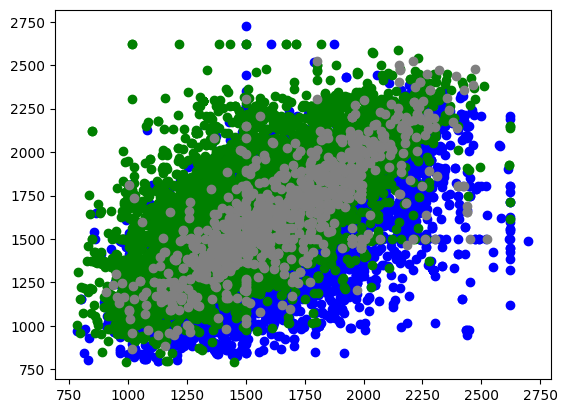

In [98]:
# Schéma représentant les parties gagné par les blanc (bleu), les parties gagné par les noir (vert) et les égalités en fonction de l'élo des deux joueurs
plt.plot(temp_white["white_rating"], temp_white["black_rating"], 'o', color='blue');
plt.plot(temp_black["white_rating"], temp_black["black_rating"], 'o', color='green');
plt.plot(temp_draw["white_rating"], temp_draw["black_rating"], 'o', color="gray")

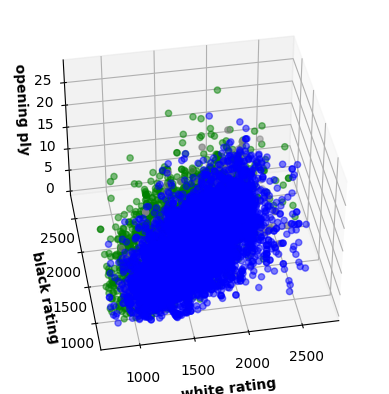

In [99]:
# Schéma représentant les parties gagné par les blanc (bleu), les parties gagné par les noir (vert) et les égalités en fonction de l'élo des deux joueurs + du nombre de coups de l'ouverture
fig = plt.figure()
ax = plt.axes(projection='3d')


ax.scatter3D(temp_white["white_rating"], temp_white["black_rating"], temp_white["opening_ply"], color="blue", alpha=0.5)
ax.scatter3D(temp_black["white_rating"], temp_black["black_rating"], temp_black["opening_ply"], color="green", alpha=0.5)
ax.scatter3D(temp_draw["white_rating"], temp_draw["black_rating"], temp_draw["opening_ply"], color="gray")


ax.set_xlabel('white rating',  fontsize=10.0, fontweight='bold')
ax.set_ylabel('black rating',  fontsize=10.0, fontweight='bold')
ax.set_zlabel('opening ply',   fontsize=10.0, fontweight='bold')

ax.view_init(40,-100)

### 2 - Traitement des données

In [100]:
X = df.drop(["id", "last_move_at", "created_at", "turns", "victory_status", "increment_code", "black_id", "white_id", "opening_name", "winner"], axis=1)
print(X.head())

   rated  white_rating  black_rating  \
0  False          1500          1191   
1   True          1322          1261   
2   True          1496          1500   
3   True          1439          1454   
4   True          1523          1469   

                                               moves opening_eco  opening_ply  
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10            5  
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00            4  
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20            3  
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02            3  
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41            5  


In [101]:
y = df["winner"]
print(y.head())

0    white
1    black
2    white
3    white
4    white
Name: winner, dtype: object


In [102]:
def evaluate_board(board):
    
    if board.is_checkmate():
        if board.turn:
            return -9999
        else:
            return 9999
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    
    material = 100*(wp-bp)+320*(wn-bn)+330*(wb-bb)+500*(wr-br)+900*(wq-bq)
    
    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq= pawnsq + sum([-pawntable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq = sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq = bishopsq + sum([-bishopstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)]) 
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)]) 
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)]) 
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KING, chess.BLACK)])
    
    eval = material + pawnsq + knightsq + bishopsq+ rooksq+ queensq + kingsq
    if board.turn:
        return eval
    else:
        return -eval

pawntable = [
 0,  0,  0,  0,  0,  0,  0,  0,
 5, 10, 10,-20,-20, 10, 10,  5,
 5, -5,-10,  0,  0,-10, -5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5,  5, 10, 25, 25, 10,  5,  5,
10, 10, 20, 30, 30, 20, 10, 10,
50, 50, 50, 50, 50, 50, 50, 50,
 0,  0,  0,  0,  0,  0,  0,  0]

knightstable = [
-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  5,  5,  0,-20,-40,
-30,  5, 10, 15, 15, 10,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 10, 15, 15, 10,  0,-30,
-40,-20,  0,  0,  0,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]

bishopstable = [
-20,-10,-10,-10,-10,-10,-10,-20,
-10,  5,  0,  0,  0,  0,  5,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10,-10,-10,-10,-10,-20]

rookstable = [
  0,  0,  0,  5,  5,  0,  0,  0,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  5, 10, 10, 10, 10, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]

queenstable = [
-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  5,  5,  5,  5,  5,  0,-10,
  0,  0,  5,  5,  5,  5,  0, -5,
 -5,  0,  5,  5,  5,  5,  0, -5,
-10,  0,  5,  5,  5,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]

kingstable = [
 20, 30, 10,  0,  0, 10, 30, 20,
 20, 20,  0,  0,  0,  0, 20, 20,
-10,-20,-20,-20,-20,-20,-20,-10,
-20,-30,-30,-40,-40,-30,-30,-20,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30]


In [103]:
board = chess.Board()
moves = X["moves"].get(0).split()[:X["opening_ply"].get(0)]
for i in range(0, X["opening_ply"].get(0)):
    board.push_san(moves[i])
print(evaluate_board(board))

-155


In [104]:
boards = []
for i in range(0, len(X)):
    moves = X["moves"].get(i).split()[:X["opening_ply"].get(i)]
    board = chess.Board()
    for j in range(0, len(moves)):
        board.push_san(moves[j])
    boards.append(board)

In [105]:
evaluating_board = []
for i in range(len(boards)):
    score = evaluate_board(boards[i])
    evaluating_board.append(score)

0 ------------>  -155
1 ------------>  -10
2 ------------>  -20
3 ------------>  -50
4 ------------>  -70
5 ------------>  95
6 ------------>  -70
7 ------------>  5
8 ------------>  10
9 ------------>  -10
10 ------------>  -20
11 ------------>  -15
12 ------------>  -70
13 ------------>  20
14 ------------>  0
15 ------------>  35
16 ------------>  0
17 ------------>  0
18 ------------>  -50
19 ------------>  0
20 ------------>  20
21 ------------>  20
22 ------------>  -70
23 ------------>  -50
24 ------------>  -90
25 ------------>  0
26 ------------>  -85
27 ------------>  0
28 ------------>  10
29 ------------>  -60
30 ------------>  -90
31 ------------>  85
32 ------------>  -100
33 ------------>  -50
34 ------------>  -70
35 ------------>  80
36 ------------>  -40
37 ------------>  -10
38 ------------>  -55
39 ------------>  0
40 ------------>  125
41 ------------>  -100
42 ------------>  -90
43 ------------>  -50
44 ------------>  -90
45 ------------>  -70
46 ------------>  0


In [106]:
# remplacement des valeurs cibles 0 = victoire blanc, 1 = victoire noir et 2 = égalité
y.replace(["white", "black", "draw"], [0, 1, 2], inplace=True)
X["rated"].replace(["True", "False"], [1, 0], inplace=True)

In [107]:
# get the dummies and store it in a variable
dummies = pd.get_dummies(X.opening_eco)
 
# Concatenate the dummies to original dataframe
merged = pd.concat([X, dummies], axis='columns')

X = merged
 
# print the dataframe
X  = X.drop(["opening_eco", "moves"], axis=1)
print(X.head())

   rated  white_rating  black_rating  opening_ply  A00  A01  A02  A03  A04  \
0  False          1500          1191            5    0    0    0    0    0   
1   True          1322          1261            4    0    0    0    0    0   
2   True          1496          1500            3    0    0    0    0    0   
3   True          1439          1454            3    0    0    0    0    0   
4   True          1523          1469            5    0    0    0    0    0   

   A05  ...  E81  E87  E88  E90  E91  E92  E94  E95  E97  E98  
0    0  ...    0    0    0    0    0    0    0    0    0    0  
1    0  ...    0    0    0    0    0    0    0    0    0    0  
2    0  ...    0    0    0    0    0    0    0    0    0    0  
3    0  ...    0    0    0    0    0    0    0    0    0    0  
4    0  ...    0    0    0    0    0    0    0    0    0    0  

[5 rows x 369 columns]


In [108]:
X["evaluating_board"] = evaluating_board
X.head()

,rated,white_rating,black_rating,opening_ply,A00,A01,A02,A03,A04,A05,...,E87,E88,E90,E91,E92,E94,E95,E97,E98,evaluating_board
0,False,1500,1191,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-155
1,True,1322,1261,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-10
2,True,1496,1500,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-20
3,True,1439,1454,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-50
4,True,1523,1469,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-70


In [109]:
# Normalisation des données
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [110]:
# création des données d'entrainement et des données de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# vérification des dimensions et du nombre de données
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16046, 370), (4012, 370), (16046,), (4012,))

### 3 - Entraînement des modèles

- En utilisant `train_test_split` (de `sklearn.model_selection`) pour diviser les données en partie entrainement et partie test.

1 - `GaussianNB` (de `sklearn.naive_bayes.GaussianNB`) pour implanter le classifieur de Bayes.

In [111]:
# instanciation du modèle naive bayes
model_baye = GaussianNB()

# entrainement du modèle
model_baye.fit(X_train, y_train)

# evaluation du modèle
model_baye.score(X_test, y_test)

0.08449651046859422

2 - `LogisticRegression` (de `sklearn.linear_model.LogisticRegression`) pour implanter la régression logistique.

In [112]:
# instanciation du modèle de regression logistique
model_logistic_regression = LogisticRegression()

# entrainement du modèle
model_logistic_regression.fit(X_train, y_train)

# evaluation du modèle
model_logistic_regression.score(X_test, y_test)

c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6186440677966102

3 - `MLPClassifier` (de `sklearn.neural_network.MLPClassifier`) pour implanter le réseau de neurones.

In [113]:
# instanciation du modèle de réseau de neuronne
model_MLP = MLPClassifier()

# entrainement du modèle
model_MLP.fit(X_train, y_train)

# evaluation du modèle
model_MLP.score(X_test, y_test)

c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6099202392821536

- En utilisant une validation croisée en $m=5$ plis `cross_validate` (de `sklearn.model_selection`) pour tester les différents algorithmes.

In [114]:
m_fold = 5

1 - `GaussianNB` (de `sklearn.naive_bayes.GaussianNB`) pour implanter le classifieur de Bayes.

In [115]:
# instanciation du modèle de Baye
model_baye = GaussianNB()

# ajout des metric accuracy et mse
scoring = ['neg_mean_squared_error', 'accuracy']

# entrainement du modele
cv_results = cross_validate(model_baye, X, y, cv=m_fold, scoring=scoring)

print(cv_results['test_accuracy']) # affiche la précision pour chaque plis
print("Accuracy of Model with Cross Validation is:", cv_results['test_accuracy'].mean(), "\n") # affiche la moyenne de précison

print(cv_results['test_neg_mean_squared_error']) # affiche le MSE pour chaque plis
print("Negative of Model with Cross Validation is:", cv_results['test_neg_mean_squared_error'].mean()) # affiche la moyenne du MSE

[0.08574277 0.08150548 0.08225324 0.08626278 0.08077786]
Accuracy of Model with Cross Validation is: 0.08330842675165727 

[-2.30508475 -2.31829511 -2.30408774 -2.25779107 -2.289454  ]
Negative of Model with Cross Validation is: -2.294942534649853


2 - `LogisticRegression` (de `sklearn.linear_model.LogisticRegression`) pour implanter la régression logistique.

In [116]:
# instanciation du modèle de regression logistique
model_logistic_regression = LogisticRegression()

# ajout des metric accuracy et mse
scoring = ['neg_mean_squared_error', 'accuracy']

# entrainement du modele
cv_results = cross_validate(model_logistic_regression, X, y, cv=m_fold, scoring=scoring)

print(cv_results['test_accuracy']) # affiche la précision pour chaque plis
print("Accuracy of Model with Cross Validation is:", cv_results['test_accuracy'].mean(), "\n") # affiche la moyenne de précison

print(cv_results['test_neg_mean_squared_error']) # affiche le MSE pour chaque plis
print("Negative of Model with Cross Validation is:", cv_results['test_neg_mean_squared_error'].mean()) # affiche la moyenne du MSE

[0.60767697 0.61241276 0.62886341 0.61655448 0.61755173]
Accuracy of Model with Cross Validation is: 0.6166118697012926 

[-0.47607178 -0.47208375 -0.44740778 -0.46123161 -0.45425081]
Negative of Model with Cross Validation is: -0.46220914668112345


3 - `MLPClassifier` (de `sklearn.neural_network.MLPClassifier`) pour implanter le réseau de neurones.

In [117]:
# instanciation du modèle de réseau de neuronne
model_MLP = MLPClassifier()

# ajout des metric accuracy et mse
scoring = ['neg_mean_squared_error', 'accuracy']

# entrainement du modele
cv_results = cross_validate(model_MLP, X, y, cv=m_fold, scoring=scoring)
sorted(cv_results)

print(cv_results['test_accuracy']) # affiche la précision pour chaque plis
print("Accuracy of Model with Cross Validation is:", cv_results['test_accuracy'].mean(), "\n") # affiche la moyenne de précison

print(cv_results['test_neg_mean_squared_error']) # affiche le MSE pour chaque plis
print("Negative of Model with Cross Validation is:", cv_results['test_neg_mean_squared_error'].mean()) # affiche la moyenne du MSE

c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

[0.60069791 0.5949651  0.61839482 0.59087509 0.58912989]
Accuracy of Model with Cross Validation is: 0.5988125625616296 

[-0.48678963 -0.5052343  -0.46834497 -0.50560957 -0.49314385]
Negative of Model with Cross Validation is: -0.49182446427856796


c:\Users\Guillaume\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 4 - Evaluation des modèles